#### Entrenar una red neuronal que de la solución de las siguientes ecuaciones diferenciales en el intervalo [-5,5]. Graficar la solución numérica junto con la solución analítica.

- (a) $xy´ + y = x^2 cosx$,   con $y(0)=0$
- (b) $y´´ = -y$,   con $y(0)= -0.5$, $y´(0)= -0.5$

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Activation
from tensorflow.keras.optimizers import RMSprop, Adam

from matplotlib import pyplot as plt
import numpy as np

In [89]:
class ODEsolver(Sequential):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.loss_tracker = keras.metrics.Mean(name='loss')
        self.mse = tf.keras.losses.MeanSquaredError()

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self,data):
        batch_size = tf.shape(data)[0]
        min = tf.cast(tf.reduce_min(data),tf.float32) #mínimo del dominio
        max = tf.cast(tf.reduce_max(data), tf.float32) #máximo del dominio
        x = tf.random.uniform((batch_size,1), minval=min, maxval=max) #puntos de colocación uniformes 

        with tf.GradientTape() as tape:
             with tf.GradientTape() as tape2:
                 tape2.watch(x) #usar x  para construir el grafo y lueo hacer la derivada 
                 y_pred = self(x, training=True) #salida de la red
             dy = tape2.gradient(y_pred, x) #derivada del modelo con respecto a entradas x
             x_o = tf.zeros((batch_size,1)) #valor de x en condicion inicial x_0=0
             y_o = self(x_o,training=True) #valor del modelo en en x_0
             eq = x*dy + y_pred - tf.cos(x)*x**2  #Ecuacion diferencial a resolver 
             ic = 0. #condición inicial
             loss = self.mse(0., eq) + self.mse(y_o,ic) 
            #minimos cuadrados, queremos que la eq se acerque a cero

        grads = tape.gradient(loss, self.trainable_variables) #gradiente de la funcion de costo 
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.loss_tracker.update_state(loss) #actualizamos parametros 
        return {"loss": self.loss_tracker.result()} #imprimir el error

In [118]:
#construimos el modelo con la función de activación tanh
model = ODEsolver()

model.add(Dense(64, activation='tanh', input_shape=(1,)))
model.add(Dense(32, activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))


model.summary()

Model: "od_esolver_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_49 (Dense)                │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,297 (12.88 KB)

 Trainable params: 3,297 (12.88 KB)

 Non-trainable params: 0 (0.00 B)

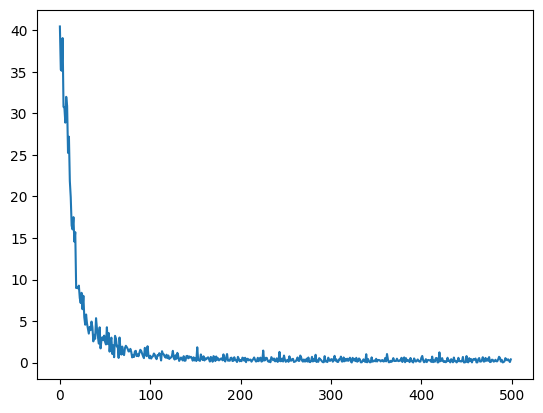

In [120]:
model.compile(optimizer=RMSprop(),metrics=['loss'])

x=tf.linspace(-5,5,200)
history = model.fit(x,epochs=500, verbose=0)
plt.plot(history.history["loss"])

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

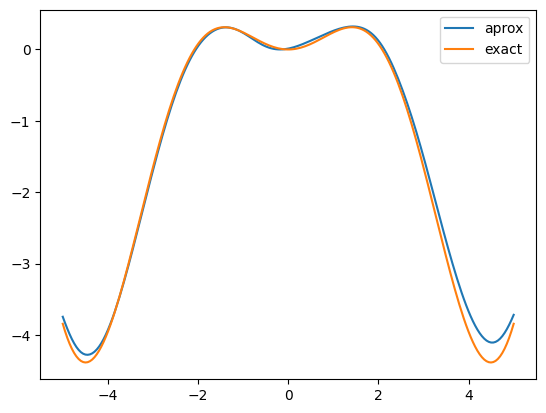

In [124]:
x_testv = tf.linspace(-5,5,200)
a = model.predict(x_testv)
plt.plot(x_testv,a,label='aprox')
#ponemos la solución de la EDO para comparar con la arrojada por la red 
plt.plot(x_testv, x*np.sin(x) + 2*np.cos(x) - 2/x * np.sin(x), label='exact') 
plt.legend()
plt.show

Hemos obtenido un buen resultado, luego de jugar un poco con el número de capas y neuronas en cada una.

Para la segunda ecuación diferencial, es necesario cambiar algunas cosas de la clase, ya que tenemos una ecuación diferencial de segundo orden y por lo tanto, otra condición inicial.

In [104]:
class ODEsolver2(Sequential):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.loss_tracker = keras.metrics.Mean(name='loss')
        self.mse = tf.keras.losses.MeanSquaredError()

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self,data):
        batch_size = tf.shape(data)[0]
        min = tf.cast(tf.reduce_min(data),tf.float32) #mínimo del dominio
        max = tf.cast(tf.reduce_max(data), tf.float32) #máximo del dominio
        x = tf.random.uniform((batch_size,1), minval=min, maxval=max) #puntos de colocación uniformes 

        with tf.GradientTape(persistent=True) as tape:
             with tf.GradientTape(persistent=True) as g:
                 g.watch(x) #usar x  para construir el grafo y luego hacer la derivada 

                 with tf.GradientTape() as gg:
                     gg.watch(x)
                     y_pred = self(x, training=True) #salida de la red
                 y_x= gg.gradient(y_pred,x) #para la primer derivada
             y_xx = g.gradient(y_x,x) #para la segunda derivada

             x_o = tf.zeros((batch_size,1)) #valor de x en condicion inicial x_0=0
             with tf.GradientTape() as tape_ic:
                 tape_ic.watch(x_o) #para usarla en dy_o
                 y_o = self(x_o,training=True) #valor del modelo en en x_0
             dy_o = tape_ic.gradient(y_o,x_o) #primera derivada evaluada en puntos inciales 
             eq = y_xx + y_pred  #Ecuacion diferencial a resolver 
             ic = 1. #condición inicial
             ic_dy = -0.5 #condición incial derivada 
             loss = self.mse(0., eq) + self.mse(y_o,ic) + self.mse(dy_o,ic_dy)
            #añadimos el mse con la segunda condición inicial

        grads = tape.gradient(loss, self.trainable_variables) #gradiente de la funcion de costo 
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.loss_tracker.update_state(loss) #actualizamos parametros 
        return {"loss": self.loss_tracker.result()} #imprimir el error

In [127]:
#construimos el modelo con la función de activación tanh
model2 = ODEsolver2()

model2.add(Dense(128, activation='tanh', input_shape=(1,)))
model2.add(Dense(64, activation='tanh'))
model2.add(Dense(32, activation= 'tanh'))
model2.add(Dense(1))


model2.summary()

Model: "od_esolver2_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_53 (Dense)                │ (None, 128)            │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,625 (41.50 KB)

 Trainable params: 10,625 (41.50 KB)

 Non-trainable params: 0 (0.00 B)

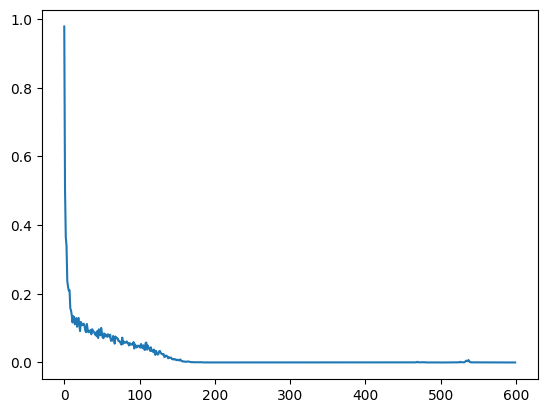

In [129]:
model2.compile(optimizer=Adam(),metrics=['loss']) 

x=tf.linspace(-5,5,200)
history = model2.fit(x,epochs=600, verbose=0)
plt.plot(history.history["loss"])

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

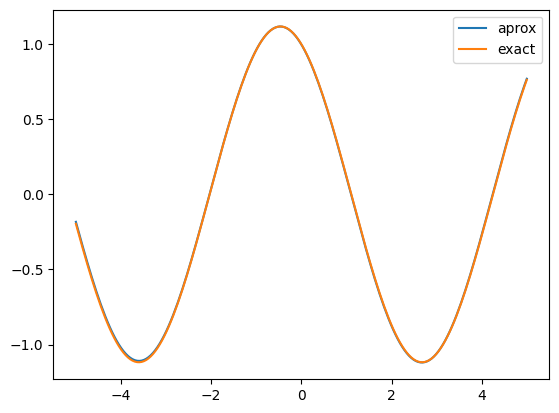

In [131]:
x_testv = tf.linspace(-5,5,200)
a = model2.predict(x_testv)
plt.plot(x_testv,a,label='aprox')
#ponemos la solución de la EDO para comparar con la arrojada por la red 
plt.plot(x_testv, np.cos(x) - 0.5*np.sin(x) , label='exact') 
plt.legend()
plt.show

De igual forma, se añadieron capas y nneuronas para obtener un buen resultado, además cambié el optimizador a Adam